# SQL Queries for a Gym Database

**Display the name and contact details of all employees who have a 'CertIII' qualification.**

```sql
SELECT E.employee_ID, E.name, E.email, E.address, E.phone, C.certifications
FROM Employee E, Certifications C
WHERE E.employee_ID = C.employee_ID AND
C.certifications = 'CertIII';

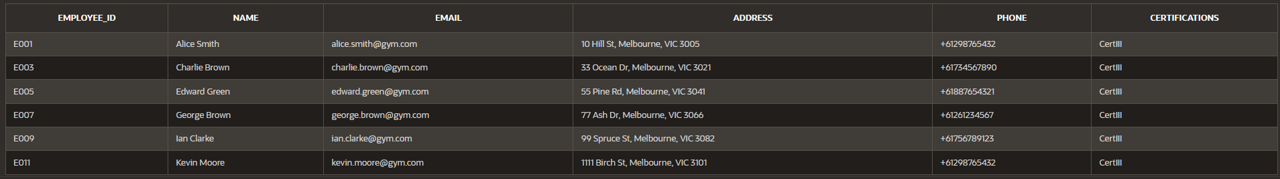

**List the contact details (name, email, and phone) for all members of the branch with ID 'B005' along with their emergency contact.**

```sql
SELECT name, email, phone, emergency_contact
FROM Member
WHERE branch_ID = 'B005'

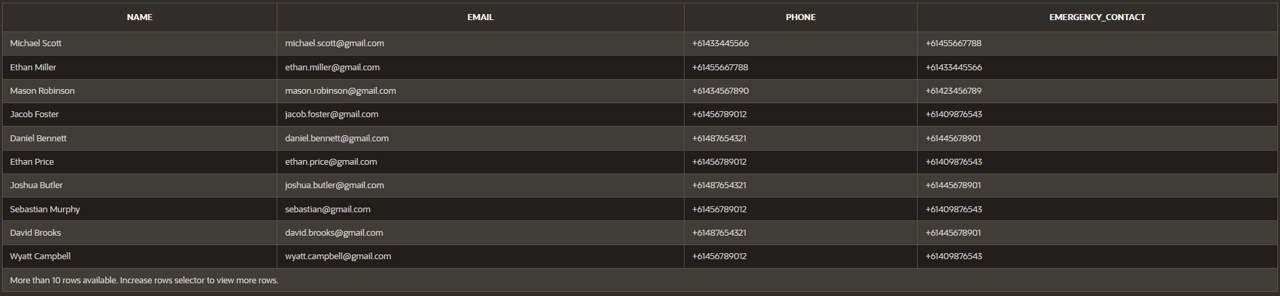

**List all maintenance work that was carried out in the last one month (30 days) in the organization. Sort them based on the maintenance date-time in descending order.**

```sql
SELECT *
FROM Maintenance
WHERE date_time >= SYSDATE - 30
ORDER BY date_time DESC;

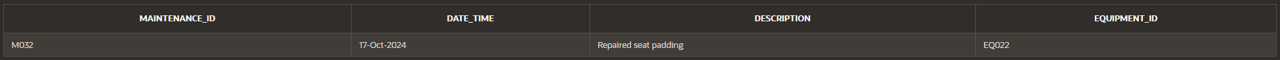

**List the IDs of all branches that have at least three strength training programs currently on offer for members to sign up for.**

```sql
SELECT C.branch_ID
FROM Crossfitprogram C, Strength S
WHERE C.program_ID = S.program_ID
GROUP BY C.branch_ID
HAVING COUNT(S.program_ID)>=3;

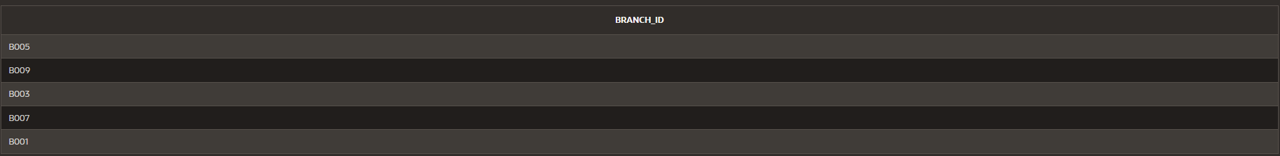

**List the branch details that have the highest number of equipment.**

```sql
SELECT B.branch_ID, B.name, B.email, B.address, B.phone
FROM BRANCH B, Equipment E
WHERE B.branch_ID = E.branch_ID
GROUP BY (B.branch_ID, B.name, B.email, B.address, B.phone)
HAVING COUNT(E.equipment_ID) 
        = (SELECT MAX(COUNT(E1.equipment_ID))
        FROM Equipment E1
        GROUP BY E1.branch_ID);

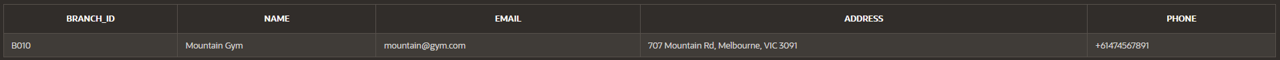

**List all equipment in the 'Central Gym' that has their next service date within the next 3 months (you can assume the time window to be 90 days).**

```sql
SELECT E.equipment_ID, E.name, E.next_service_date
FROM Equipment E, Branch B
WHERE E.branch_ID = B.branch_ID AND
B.name = 'Central Gym' AND
E.next_service_date >= SYSDATE AND
E.next_service_date <= SYSDATE + 90;

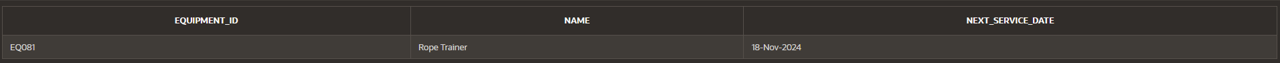

**List all members and their health conditions who have signed up for a HIIT program that is currently ongoing.**

```sql
SELECT M.member_ID, M.name, MC.name AS "Condition Name"
FROM Member M, Mem_medical_condition MC, Hiit H, Sign_up S, Crossfitprogram C
WHERE M.member_ID = MC.member_ID AND S.member_ID = M.member_ID
AND S.program_ID = H.program_ID AND C.program_ID = S.program_ID
AND C.start_date < SYSDATE
AND C.end_date > SYSDATE;


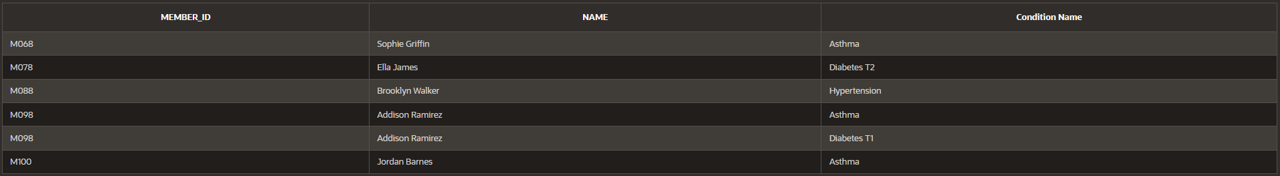

**Display the title and the lead trainer’s name for the CrossFit program(s) that has the longest duration.**

```sql
SELECT C.title, E.name
FROM Crossfitprogram C, Employee E
WHERE C.lead_trainer_id = E.employee_ID
AND C.Duration = (SELECT MAX(C1.Duration) FROM Crossfitprogram C1);

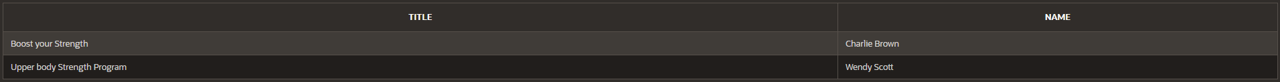

**List the name, email, and phone of all employees who are either assisting or leading the strength training program with ID 'P001'.**

```sql
SELECT E.name, E.phone, E.email
FROM Employee E, Crossfitprogram C
WHERE C.program_ID = 'P001' AND
C.lead_trainer_id = E.employee_ID
UNION
SELECT E.name, E.phone, E.email
FROM Employee E, Assist A
WHERE A.program_ID = 'P001' AND
A.employee_ID = E.employee_ID;

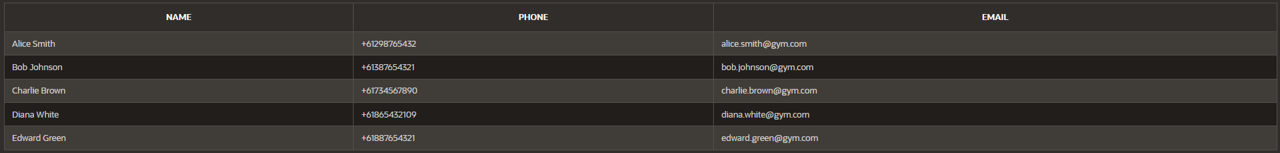

**List all branches (id and name) that have greater than the average number of members among all branches.**

```sql
SELECT B.branch_ID, B.name
FROM Branch B, Member M
WHERE B.branch_ID = M.branch_ID
GROUP BY (B.branch_ID, B.name)
HAVING COUNT(M.member_ID) > (SELECT AVG (COUNT(M1.member_ID))
                             FROM Member M1
                             GROUP BY M1.branch_ID);


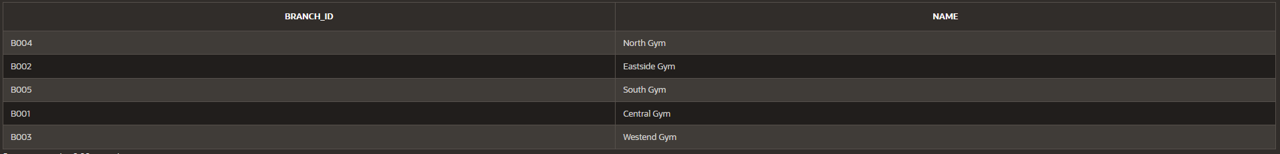

**Create a stored procedure that accepts a program id as input and prints a report on the screen in the format specified in the example below:**

```sql
-----------------------------------------------
Program title: Boost your core strength
Program type: Stregnth
State date: 17 October 2024
Lead trainer name: Matthew Williams
Number of additional trainers: 4
-----------------------------------------------
Current members in the program:
Roger Federer
Raphael Nadal
Andy Murray
Recommended daily calorie intake: 4000 (minimum)
----------------------------------------------------------------

```sql
CREATE OR REPLACE PROCEDURE CreateReport(
p_programID Crossfitprogram.program_ID%type
)
AS
v_title Crossfitprogram.title%type;
v_programType VARCHAR2(10);
v_startdate Crossfitprogram.start_date%type;
v_leadtrainer Employee.name%type;
v_additionalTrainers NUMBER;
v_members VARCHAR2(100);
v_calories NUMBER;
v_caloriesminvsmax VARCHAR2 (10);

CURSOR cursor_members IS
    SELECT M.name
    FROM Member M, Sign_up S
    WHERE S.program_ID = p_programID AND M.member_ID = S.member_ID;

BEGIN 

SELECT C.title, C.start_date, E.name
INTO v_title, v_startdate, v_leadtrainer
FROM Crossfitprogram C, Employee E
WHERE C.program_ID = p_programID AND
C.lead_trainer_id = E.employee_ID;

SELECT COUNT(*)
INTO v_additionalTrainers
FROM Assist A
WHERE A.program_ID = p_programID;

    BEGIN
    SELECT H.maximum_daily_calorie
    INTO v_calories
    FROM HIIT H
    WHERE p_programID = H.program_ID;
    v_programType := 'HIIT';
    v_caloriesminvsmax := '(maximum)';

    EXCEPTION
    WHEN NO_DATA_FOUND THEN
        BEGIN
        SELECT S.minimum_daily_calorie
        INTO v_calories
        FROM Strength S
        WHERE p_programID = S.program_ID;
        v_programType := 'Strength';
        v_caloriesminvsmax := '(minimum)';
        END;
    END;

DBMS_OUTPUT.PUT_LINE('------------------------------------');
DBMS_OUTPUT.PUT_LINE('Program title: ' || v_title );
DBMS_OUTPUT.PUT_LINE('Program type: ' || v_programType);
DBMS_OUTPUT.PUT_LINE('Start date: ' || TO_CHAR (v_startdate, 'DD Month YYYY'));
DBMS_OUTPUT.PUT_LINE('Lead trainer name: ' || v_leadtrainer);
DBMS_OUTPUT.PUT_LINE('Number of additional trainers: ' || v_additionalTrainers);
DBMS_OUTPUT.PUT_LINE('------------------------------------');

DBMS_OUTPUT.PUT_LINE('Current members in the program:');
FOR member_names in cursor_members LOOP
    DBMS_OUTPUT.PUT_LINE(member_names.name);
END LOOP;
DBMS_OUTPUT.PUT_LINE('');
DBMS_OUTPUT.PUT_LINE('Recommended daily calorie intake: ' || '' || v_calories || ' ' || v_caloriesminvsmax);
DBMS_OUTPUT.PUT_LINE('------------------------------------');

END CreateReport;
/


**Code for execution**

```sql
BEGIN
  CreateReport('P001');
END;

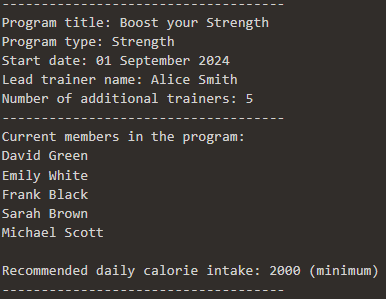

**Create a stored function that accepts a gold club member’s id as input and returns the total number of events the member has attended so far. If the member did not attend any events, the function must return zero.**

**To demonstate the functionality of the stored function, write a select statement to display the name along with the number of events attended by all employees of the stay fit company who are also gold club members.**

```sql
CREATE OR REPLACE FUNCTION EventAttendance (
    p_goldID goldclubmember.gold_club_member_id%TYPE
)

RETURN NUMBER IS
v_eventsAttended NUMBER;

BEGIN
SELECT COUNT(A.event_id)
INTO v_eventsAttended
FROM ATTEND A
WHERE A.gold_club_member_id = p_goldID;

RETURN v_eventsAttended;

EXCEPTION
    WHEN NO_DATA_FOUND THEN
    RETURN 0;


END EventAttendance;
/

**Test functionality**
```sql
SELECT E.name, EventAttendance(E.gold_club_member_id) AS "Number of Events Attended"
FROM Employee E
WHERE E.gold_club_member_id IS NOT NULL;

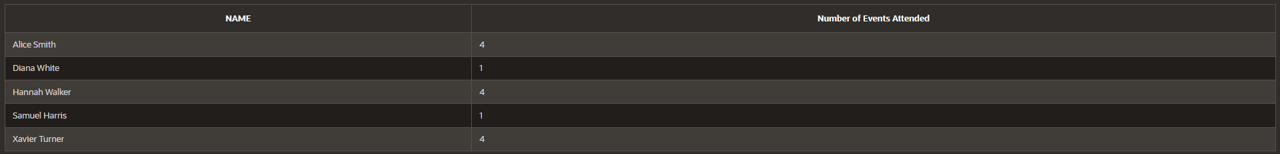

**Create a trigger that prevents a member who has ‘Cardiomyopathy’ from signing up for a HIIT program.**

```sql
CREATE OR REPLACE TRIGGER PreventSignupTrigger
BEFORE INSERT OR UPDATE ON Sign_up FOR EACH ROW
DECLARE
v_medicalCondition Mem_Medical_Condition.name%TYPE;
v_programType VARCHAR2(10);

BEGIN
SELECT MC.name
INTO v_medicalCondition
FROM Mem_Medical_Condition MC
WHERE MC.member_ID =: new.member_ID;

IF v_medicalCondition = 'Cardiomyopathy' THEN
SELECT 'HIIT' INTO v_programType
FROM HIIT H
WHERE H.program_ID =: new.program_ID;

IF v_programType = 'HIIT' THEN
    RAISE_APPLICATION_ERROR(-20001, 'If member has cardiomyopathy, they cannot sign up for HIIT programs.');
END IF;
END IF;

END PreventSignupTrigger;
/


**Test functionality**
```sql
INSERT INTO Sign_up (member_ID, program_ID)
VALUES ('M033', 'P002')

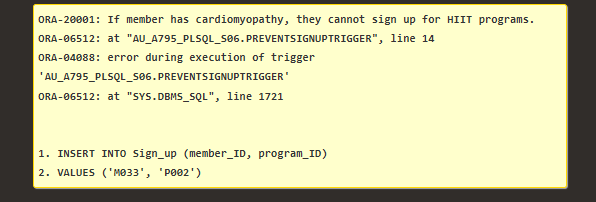

**Create a trigger on the number_in_stock attribute of the supplements table that prints a warning message along with the supplier details, if the supplement is a protein supplement and the stock is updated to a value below 10. You are free to determine the content of the warning message.**

```sql
CREATE OR REPLACE TRIGGER LowStockTrigger
AFTER UPDATE ON Supplements FOR EACH ROW
DECLARE
v_supplierName Supplier.business_name%TYPE;
v_supplierEmail Supplier.email%TYPE;
v_supplierPhone Supplier.phone%TYPE;

BEGIN

IF :new.number_in_stock <10 THEN

SELECT SP.business_name, SP.email, SP.phone
INTO v_supplierName, v_supplierEmail, v_supplierPhone
FROM Supplier SP, ProteinSupplements PS
WHERE :new.supplement_id = PS.supplement_id AND PS.supplier_id = SP.supplier_id;


DBMS_OUTPUT.PUT_LINE('Your stock numbers for ' ||'' || :new.product_name ||'' || ' are low. It is time for a restock.');
DBMS_OUTPUT.PUT_LINE('The details for the supplier are: ');
DBMS_OUTPUT.PUT_LINE('Supplier name: ' || v_supplierName);
DBMS_OUTPUT.PUT_LINE('Email: ' || v_supplierEmail);
DBMS_OUTPUT.PUT_LINE('Phone: ' || v_supplierPhone);
END IF;

END LowStockTrigger;
/


**Test functionality**
```sql
UPDATE Supplements
SET number_in_stock = 9
WHERE Supplement_id = 'S001';

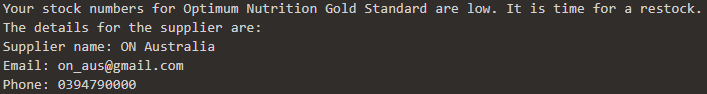